# Some ideas for spectral MC Simulations

In [1]:
import luxpy as lx
import numpy as np

%matplotlib inline


from empir19nrm02.spectral import McSpectrumX
from empir19nrm02.tools import plotHistScales, plotHistScalesWl, plotHistScalesValue, \
                              array2analyse, analyse_stat, seaborn_plot_basedata, seaborn_plot_result
from empir19nrm02.f1prime import py_f1PrimeG

# Parameter for the simulation
#### Let's modify some standard data first and caculate some integrated valeus like $f_{1}^{'}$ and Yxy tristimulus values

In [2]:
strWeighting = 'A'
strObserver = '1931_2'
# let's use the V(Lambda) Function (0 ... X, 1...Y, 2...Z)
iObserverOffset = 1
wlResolution = 5
wlStart = 380
wlStop = 780
trials = 10000

# MC Simulation
Define some data to work with (let's start with the $V(\lambda)$ function)


In [3]:
lxCmf = lx._CMF['1931_2']
lxCmfInterpolate = lx.cie_interp(lxCmf['bar'], \
    wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
    kind = 'S')
res = len(lxCmfInterpolate[0])

# Data storage
Take a nominal wavelength scale and the ideal detector and sore all together into a class instance SPD from luxpy

In [4]:
wl=lxCmfInterpolate[0].reshape(1,res)
value=lxCmfInterpolate[2].reshape(1,res)
spd_init = np.r_[wl, value]

# Scale to recerence?
True    all graphs will be shown as difference to the reference
False   all graphs will be shown as they are (without referencing the data)

In [5]:
scale_to_reference = True

# MC Steps?
All MC simulation include several steps (one step for every parameter in the model). The useage of these steps can be
selected here.

At the end, all selected parameters needs to be switched on together for the combined uncertainty.

In [6]:
mc_enable = { 'wl_noise_nc': True,
              'wl_noise_c': True,
              'value_noise_nc': True,
              'value_noise_c': True,
              'value_fourier_noise':True,
              'all': True,
              }

### Array contining instances of the class SPD to store the results of the MC simulation

In [7]:
array_mc = np.ndarray((trials,),dtype=object)

### Array contining the integral results (here $f_{1}^{'}$ for an scalar output)

In [8]:
result1 = np.zeros( trials)

### Array contining the integral results (here Yxy for a moredimensional  output)

In [9]:
result3 = np.zeros( (3, trials))

# Running the MC simulation

i= all
Statistic for the wavelength scale
Value= [0.013689728577231866, 1.417530244663794] Inteval(95%)= 5.388289629930682


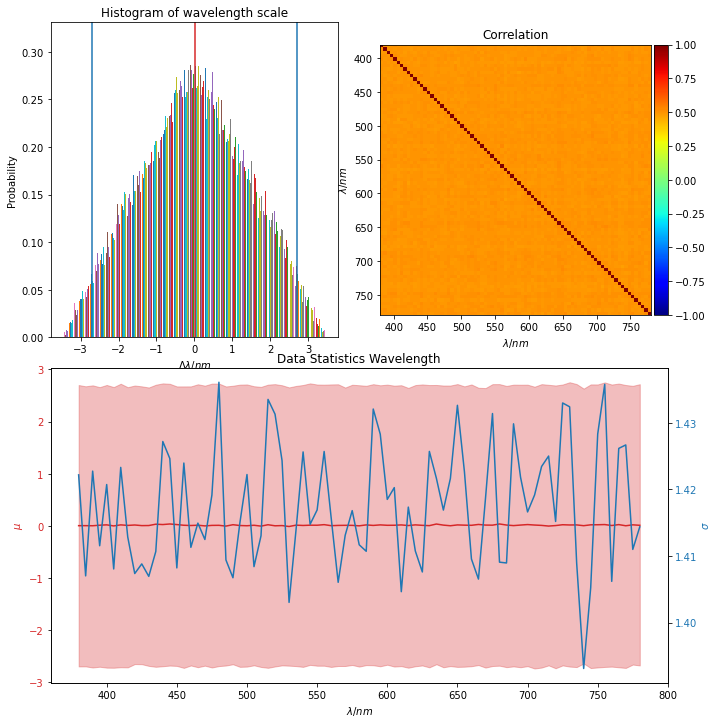

Value= [-5.785467868096869e-06, 0.015136436345132568] Inteval(95%)= 0.05949913061927359
Statistic for the value scale


E:\TTBV\Python\empir19nrm02\empir19nrm02\tools\plotting.py:83: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Value= [-5.785467868096869e-06, 0.015136436345132568] Inteval(95%)= 0.05949913061927359


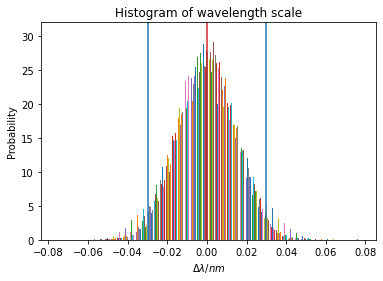

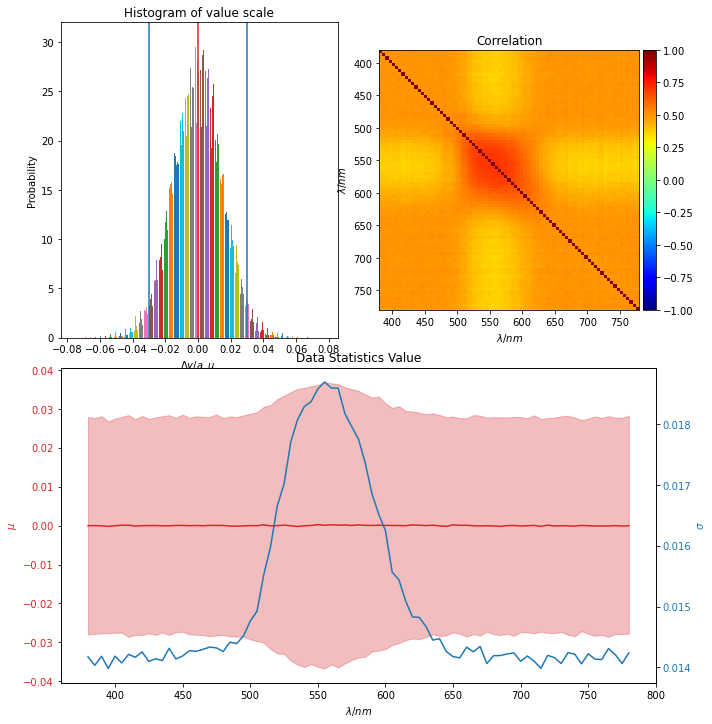

Value= [-5.785467868096869e-06, 0.015136436345132568] Inteval(95%)= 0.05949913061927359
Statistic for the scalar result
Value= [5.931664054015006, 2.1458328018894384] Inteval(95%)= 8.074073757002225


E:\TTBV\Python\empir19nrm02\empir19nrm02\tools\plotting.py:83: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


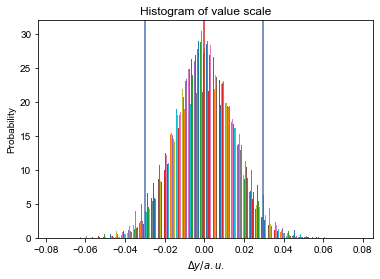

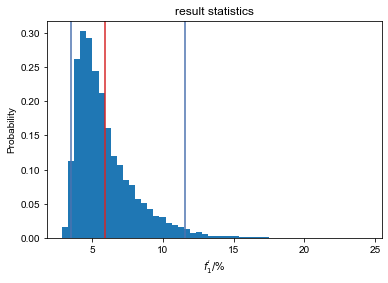

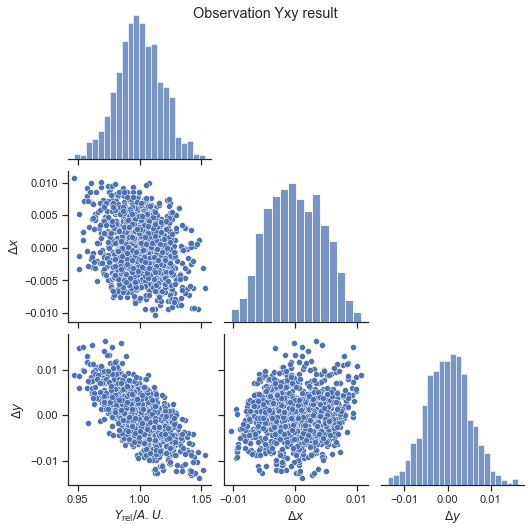

In [10]:
for iMC in ['all']:
#for iMC in mc_enable:
    # do nothing if a contribution is not enabled
    if mc_enable[iMC] == False: continue

    # initialise the result data arrays
    result1.fill(0)
    result3.fill(0)

    # init the spectral array with the reference distribution to add some noise later on
    for i in range(trials):
        array_mc[i] = McSpectrumX(spd_init)

    # for all trials
    for i in range(0, trials):
        # no noise for the first item as reference for later investigations
        if i != 0:
            if mc_enable['wl_noise_nc'] and (iMC == 'wl_noise_nc' or iMC == 'all'):
                array_mc[i].add_wl_noise_nc( 0., 1., distribution='uniform')
            if mc_enable['wl_noise_c'] and (iMC == 'wl_noise_c' or iMC == 'all'):
                array_mc[i].add_wl_noise_c( 0., 1., distribution='uniform')
            if mc_enable['value_noise_nc'] and (iMC == 'value_noise_nc' or iMC == 'all'):
                array_mc[i].add_value_noise_nc( 0., 0.01, distribution='normal')
            if mc_enable['value_noise_c'] and (iMC == 'value_noise_c' or iMC == 'all'):
                array_mc[i].add_value_noise_c( 0., 0.01, distribution='normal')
            if mc_enable['value_fourier_noise'] and (iMC == 'value_fourier_noise' or iMC == 'all'):
                array_mc[i].add_value_fourier_noise( array_mc[0], 1, stddev=0.01)

        # calculate some sample integral data from the generated distribution
        [result1[i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value)
        result3[:,i] = lx.xyz_to_Yxy(array_mc[i].spd.to_xyz(relative=False).value)


    print("i=", iMC)

    if iMC=='all':
        # Show all the graphs only for the final result
        analyse = array2analyse(array_mc, wavelength_stat = False, scale_to_ref=scale_to_reference)
        print('Statistic for the wavelength scale')
        analyse_stat( array_mc, wavelength_stat = True, scale_to_ref=scale_to_reference)
        plotHistScalesWl( analyse)

        print('Statistic for the value scale')
        analyse_stat( array_mc, wavelength_stat = False, scale_to_ref=scale_to_reference)
        plotHistScalesValue( analyse)

        print('Statistic for the scalar result')
        plotHistScales( 100.*result1, title = "result statistics", xLabel="$f_{1}^{'} / \%$")
        seaborn_plot_result( result3)

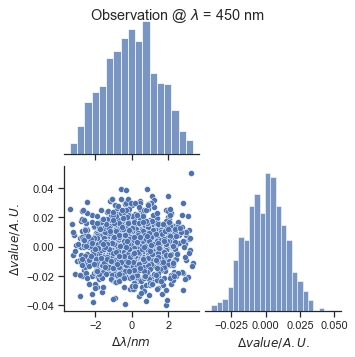

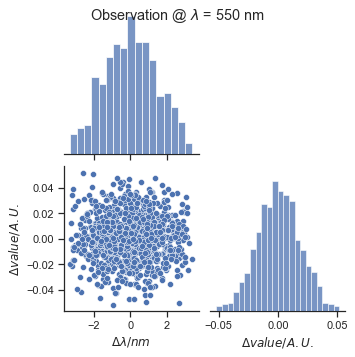

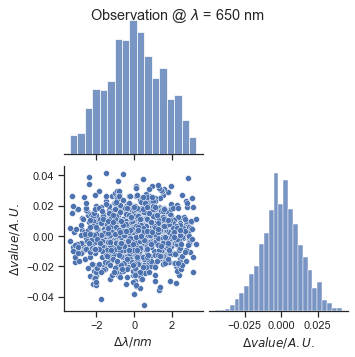

In [11]:
seaborn_plot_basedata(array_mc, wavelength_to_observe = 450)
seaborn_plot_basedata(array_mc, wavelength_to_observe = 550)
seaborn_plot_basedata(array_mc, wavelength_to_observe = 650)

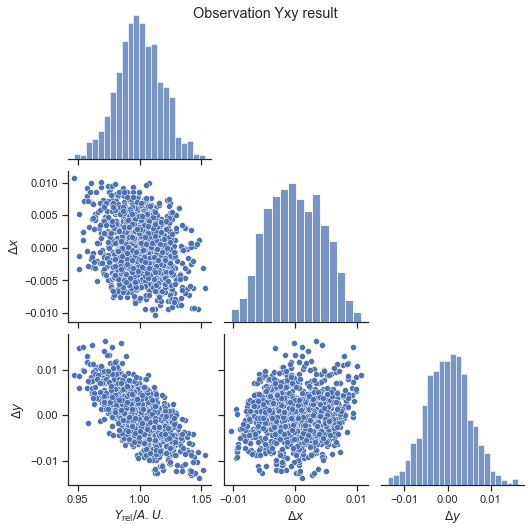

In [12]:
seaborn_plot_result( result3)

In [13]:
#mcComponents = 4
#
#array = np.ndarray((trials,),dtype=object)
#for i in range(trials):
#    array[i] = McSpectrumX(spd_init)
#
#for iMC in range(mcComponents):
#    for jMC in range(iMC,mcComponents):
#        print (iMC, jMC)
#        str = 'MCFile_{}_{}'
#        fileName = str.format(iMC, jMC)
#        np.save( fileName, array)
#
